### Downloading the dataset

In [1]:
!nvidia-smi

Tue Apr 13 12:06:40 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import shutil
import os
try:
    shutil.rmtree("inaturalist_12K")
except:
    pass

try:
    os.remove("nature_12K.zip")
except:
    pass

try:
    shutil.rmtree("wandb")
except:
    pass

In [3]:
!gdown https://drive.google.com/uc?id=1AWK5fe-W29Bry_GytbDMqoFwQXVom56s

Downloading...
From: https://drive.google.com/uc?id=1AWK5fe-W29Bry_GytbDMqoFwQXVom56s
To: /content/nature_12K.zip
3.82GB [01:10, 53.9MB/s]


In [4]:
%%capture
!unzip "/content/nature_12K.zip"

In [5]:
%%capture
! pip install wandb

In [6]:
!find . -name "*.DS_Store" -type f -delete

### Importing libraries

In [7]:
import numpy as np
import os
import matplotlib.pyplot as plt
import keras
from keras.layers import Conv2D , MaxPool2D , Flatten , Dropout, Dense, Activation, BatchNormalization
from keras.optimizers import Adam
from sklearn.metrics import classification_report,confusion_matrix
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras.models import Sequential, load_model
import random
import wandb
import shutil
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
from wandb.keras import WandbCallback
from keras.utils.vis_utils import plot_model

### Exploring the data

In [8]:
# list of class names
temp = os.listdir("inaturalist_12K/train")
class_names = [name for name in temp if name != ".DS_Store"]
print("The names of the classes are:")
print(class_names)

num_classes = len(class_names)
print(f"Number of classes = {num_classes}\n")

M = 0
M_test = 0

for each_class in class_names:
    train_images = os.listdir("inaturalist_12K/train/"+each_class)
    test_images = os.listdir("inaturalist_12K/val/"+each_class)
    filtered_train_images = list(filter(lambda x: x!=".DS_Store", train_images))
    filtered_test_images = list(filter(lambda x: x!=".DS_Store", test_images))
    M = M + len(filtered_train_images)
    M_test = M_test + len(filtered_test_images)

print(f"Total number of training images = {M}")
print(f"Total number of test images = {M_test}\n")

The names of the classes are:
['Mollusca', 'Amphibia', 'Fungi', 'Insecta', 'Plantae', 'Aves', 'Arachnida', 'Reptilia', 'Mammalia', 'Animalia']
Number of classes = 10

Total number of training images = 9999
Total number of test images = 2000



In [9]:
input_image_shape = (224, 224, 3)

### Creating validation set

In [10]:
# Fraction of images to use in the validationset
validation_split_fraction = 0.1

try:
    shutil.rmtree("inaturalist_12K/validation/")
except:
    pass
    
# Create a new directory for the validation set
os.mkdir("inaturalist_12K/validation/")

for each_class in class_names:
    os.mkdir("inaturalist_12K/validation/"+each_class)
    train_images = os.listdir("inaturalist_12K/train/"+each_class)
    filtered_train_images = list(filter(lambda x: x!=".DS_Store", train_images))
    count = len(filtered_train_images)
    random.shuffle(filtered_train_images) # Shuffle the training images

    validation_images = filtered_train_images[:round(validation_split_fraction*count)]

    for im in validation_images:
        shutil.move("inaturalist_12K/train/"+each_class+"/"+im, "inaturalist_12K/validation/"+each_class+"/"+im)

### Set up the training, validation and test generators

In [11]:
def make_generators(train_batch_size, data_aug):
    if data_aug:
        train_datagen = ImageDataGenerator(rescale=1./255,
                                        height_shift_range=0.2,
                                        width_shift_range=0.2,
                                        horizontal_flip=True,
                                        zoom_range=0.2,
                                        fill_mode="nearest")
    else:
        train_datagen = ImageDataGenerator(rescale=1./255)

    val_datagen = ImageDataGenerator(rescale=1./255)

    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        'inaturalist_12K/train',
        target_size=input_image_shape[:2],
        color_mode="rgb",
        batch_size=train_batch_size,
        class_mode='categorical',
        shuffle=True,
        seed=42)

    # batch_size for validation and test generator should perfectly divide the total number of examples
    validation_generator = val_datagen.flow_from_directory(
        'inaturalist_12K/validation',
        target_size=input_image_shape[:2],
        color_mode="rgb",
        batch_size=100,
        class_mode='categorical',
        shuffle=True,
        seed=42)

    test_generator = test_datagen.flow_from_directory(
        'inaturalist_12K/val',
        target_size=input_image_shape[:2],
        color_mode="rgb",
        batch_size=100,
        class_mode=None,
        shuffle=False,
        seed=42)
    
    return train_generator, validation_generator, test_generator

### Building the model

In [12]:
def define_model(activation_function_conv, activation_function_dense, num_filters, shape_of_filters_conv, shape_of_filters_pool, batch_norm_use, fc_layer, dropout):
    model = Sequential()
    model.add(Conv2D(num_filters[0], shape_of_filters_conv[0], input_shape=input_image_shape))
    if batch_norm_use:
        model.add(BatchNormalization())
    model.add(Activation(activation_function_conv[0]))
    model.add(MaxPool2D(pool_size=shape_of_filters_pool[0], strides = (2, 2)))

    for i in range(1, 5):
        model.add(Conv2D(num_filters[i], shape_of_filters_conv[i]))
        if batch_norm_use:
            model.add(BatchNormalization())
        model.add(Activation(activation_function_conv[i]))
        model.add(MaxPool2D(pool_size=shape_of_filters_pool[i], strides = (2, 2)))

    model.add(Flatten()) # The flatten layer is essential to convert the feature map into a column vector
    model.add(Dense(fc_layer, activation=activation_function_dense))
    model.add(Dropout(dropout)) # For regularization
    model.add(Dense(10, activation="softmax"))
    return model

In [13]:
def train_validate_model(train_batch_size, data_aug, activation_function_conv, activation_function_dense, num_filters, shape_of_filters_conv, shape_of_filters_pool, batch_norm_use, fc_layer, dropout):
    
    # Create the data generators
    if data_aug:
        train_datagen = ImageDataGenerator(rescale=1./255,
                                        height_shift_range=0.2,
                                        width_shift_range=0.2,
                                        horizontal_flip=True,
                                        zoom_range=0.2,
                                        fill_mode="nearest")
    else:
        train_datagen = ImageDataGenerator(rescale=1./255)

    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        'inaturalist_12K/train',
        target_size=input_image_shape[:2],
        color_mode="rgb",
        batch_size=train_batch_size,
        class_mode='categorical',
        shuffle=True,
        seed=42)

    test_generator = test_datagen.flow_from_directory(
        'inaturalist_12K/val',
        target_size=input_image_shape[:2],
        color_mode="rgb",
        batch_size=train_batch_size,
        class_mode=None,
        shuffle=False,
        seed=42)
    
    # Define the model
    model = define_model(activation_function_conv, activation_function_dense, num_filters, shape_of_filters_conv, shape_of_filters_pool, batch_norm_use, fc_layer, dropout)

    # Compute the validation step size
    TRAIN_STEP_SIZE = train_generator.n//train_generator.batch_size

    model.compile(optimizer=Adam(lr=0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

    history = model.fit(train_generator,
                        steps_per_epoch = TRAIN_STEP_SIZE,
                        epochs=18,
                        verbose=2)
    
    plt.plot(history.history['accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Training accuracy')
    plt.xlabel('Epoch')
    plt.show()
    
    plt.plot(history.history['loss'])
    plt.title('Model loss')
    plt.ylabel('Training loss')
    plt.xlabel('Epoch')
    plt.show()
    
    return history, model

In [14]:
def train_validate_model_wandb():
    # Default values for hyper-parameters
    config_defaults = {
        "data_aug": True,
        "train_batch_size": 128,
        "batch_norm_use": True,
        "dropout": 0,
        "num_filters": [16, 32, 64, 128, 256],
        "fc_layer": 256,
        "shape_of_filters_conv": [(3, 3), (3, 3), (3, 3), (3, 3), (3, 3)]
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config

    # Local variables, values obtained from wandb config
    num_filters = config.num_filters
    data_aug = config.data_aug
    train_batch_size = config.train_batch_size
    batch_norm_use = config.batch_norm_use
    dropout = config.dropout
    fc_layer = config.fc_layer
    shape_of_filters_conv = config.shape_of_filters_conv
    
    # Display the hyperparameters
    run_name = "aug_{}_bs_{}_bn_{}_drop_{}_fc_{}_fil_{}_shape_{}".format(data_aug, train_batch_size, batch_norm_use, dropout, fc_layer, num_filters, shape_of_filters_conv)
    print(run_name)

    # Create the data generators
    train_generator, validation_generator, test_generator = make_generators(train_batch_size, data_aug)
    
    # Define the model
    model = define_model(activation_function_conv, activation_function_dense, num_filters, shape_of_filters_conv, shape_of_filters_pool, batch_norm_use, fc_layer, dropout)
    print(model.count_params())

    TRAIN_STEP_SIZE = train_generator.n//train_generator.batch_size
    VALIDATION_STEP_SIZE = validation_generator.n//validation_generator.batch_size

    model.compile(optimizer=Adam(lr=0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

    # Early Stopping callback
    earlyStopping = EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='min')

    # To save the model with best validation accuracy
    mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)

    history = model.fit(train_generator,
                        steps_per_epoch = TRAIN_STEP_SIZE,
                        validation_data = validation_generator,
                        validation_steps = VALIDATION_STEP_SIZE,
                        epochs=10, 
                        callbacks=[WandbCallback(data_type="image", generator=validation_generator), earlyStopping, mc],
                        verbose=2)
    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    
    # Meaningful name for the run
    wandb.run.name = run_name
    wandb.run.save()
    wandb.run.finish()
    return history

### Training a model with the best set of hyperparameters

In [15]:
# Transferring the validation images back into the training set
for each_class in class_names:
    # Get the validation images of each class
    validation_images = os.listdir("inaturalist_12K/validation/"+each_class)
    filtered_vaidation_images = list(filter(lambda x: x!=".DS_Store", validation_images))

    for im in filtered_vaidation_images:
        # Transfer images from the validation to training folders
        shutil.move("inaturalist_12K/validation/"+each_class+"/"+im, "inaturalist_12K/train/"+each_class+"/"+im)

Found 9999 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
Epoch 1/18
78/78 - 241s - loss: 2.2010 - accuracy: 0.2361
Epoch 2/18
78/78 - 208s - loss: 2.0031 - accuracy: 0.2894
Epoch 3/18
78/78 - 199s - loss: 1.9317 - accuracy: 0.3156
Epoch 4/18
78/78 - 198s - loss: 1.8831 - accuracy: 0.3324
Epoch 5/18
78/78 - 197s - loss: 1.8461 - accuracy: 0.3511
Epoch 6/18
78/78 - 197s - loss: 1.8148 - accuracy: 0.3613
Epoch 7/18
78/78 - 197s - loss: 1.7837 - accuracy: 0.3701
Epoch 8/18
78/78 - 196s - loss: 1.7536 - accuracy: 0.3773
Epoch 9/18
78/78 - 196s - loss: 1.7386 - accuracy: 0.3879
Epoch 10/18
78/78 - 196s - loss: 1.7077 - accuracy: 0.3981
Epoch 11/18
78/78 - 196s - loss: 1.6731 - accuracy: 0.4141
Epoch 12/18
78/78 - 196s - loss: 1.6587 - accuracy: 0.4155
Epoch 13/18
78/78 - 196s - loss: 1.6442 - accuracy: 0.4265
Epoch 14/18
78/78 - 199s - loss: 1.6252 - accuracy: 0.4265
Epoch 15/18
78/78 - 196s - loss: 1.6073 - accuracy: 0.4356
Epoch 16/18
78/78 - 199s - loss: 1.591

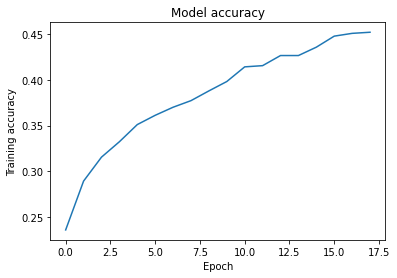

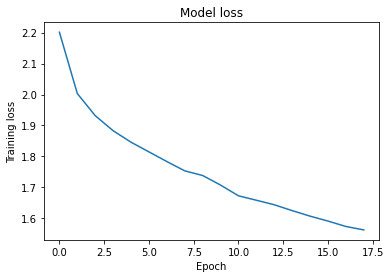

INFO:tensorflow:Assets written to: best_model_dl_2/assets


In [16]:
# These are the hyperparameters that we do not sweep over
activation_function_conv = ["relu", "relu", "relu", "relu", "relu"]
activation_function_dense = "relu"
shape_of_filters_pool = [(2, 2), (2, 2), (2, 2), (2, 2), (2, 2)]

# Best values of hyperparameters chosen using wandb sweeps
data_aug = True
train_batch_size = 128
batch_norm_use = True
dropout = 0.1

# Number of filters in each layer
num_filters = [32, 64, 128, 256, 512]
# Number of neurons in the dense/fully connected layer
fc_layer = 512
# Shape of the filters used in each of the five layers
shape_of_filters_conv = [(3, 3), (3, 3), (3, 3), (5, 5), (7, 7)]

# Training the model
history, model = train_validate_model(train_batch_size,
                               data_aug,
                               activation_function_conv,
                               activation_function_dense,
                               num_filters,
                               shape_of_filters_conv, 
                               shape_of_filters_pool,
                               batch_norm_use,
                               fc_layer,
                               dropout)

# Save the model
model.save("best_model_dl_2")

In [17]:
# Saving the model in H5 format
model.save("best_cnn_model.h5")

In [18]:
# from google.colab import drive
# drive.mount('/content/drive')
# model.save("/content/drive/My Drive/DataAnalyticsLAB/Project_Dataset/best_model_dl_2")

#### Model Summary

In [19]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 222, 222, 32)      128       
_________________________________________________________________
activation (Activation)      (None, 222, 222, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 109, 109, 64)      256       
_________________________________________________________________
activation_1 (Activation)    (None, 109, 109, 64)      0

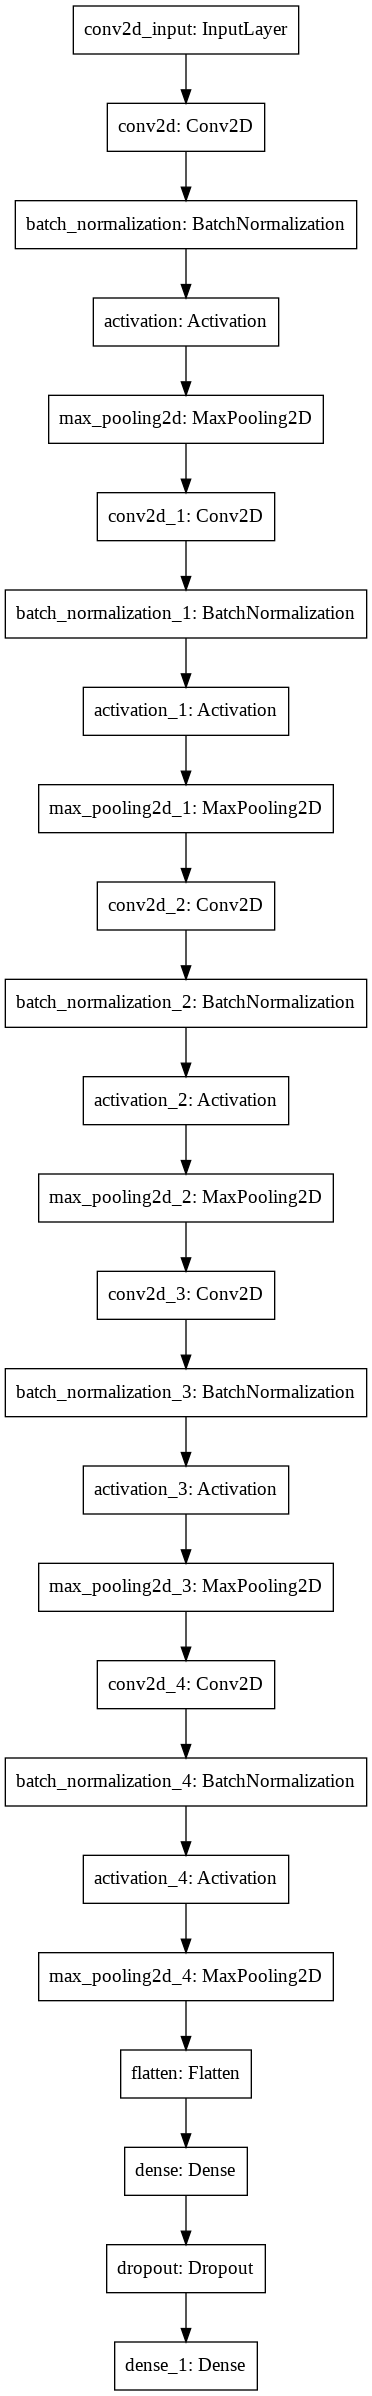

In [20]:
plot_model(model)

## Testing and Prediction Section

In [21]:
# Import libraries
import numpy as np
import os
import matplotlib.pyplot as plt
import keras
from keras.layers import Conv2D , MaxPool2D , Flatten , Dropout, Dense, Activation, BatchNormalization
from keras.optimizers import Adam
from sklearn.metrics import classification_report,confusion_matrix
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras.models import Sequential, load_model
import random
import wandb
import shutil
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
from wandb.keras import WandbCallback
from keras.utils.vis_utils import plot_model

### Loading the saved model

In [22]:
!gdown https://drive.google.com/uc?id=1PDD1yFroe89wlwqQB_--bq3mDxwvTHyY

Downloading...
From: https://drive.google.com/uc?id=1PDD1yFroe89wlwqQB_--bq3mDxwvTHyY
To: /content/best_cnn_model.h5
101MB [00:03, 33.4MB/s] 


In [23]:
# Load the saved model
from keras.models import load_model
model = load_model("best_cnn_model.h5")
# Input image shape
input_image_shape = (224, 224, 3)

### Predictions

##### Training set

In [24]:
# Predictions on the training set

# Create a train data generator
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
        'inaturalist_12K/train',
        target_size=input_image_shape[:2],
        color_mode="rgb",
        batch_size=128,
        class_mode='categorical',
        shuffle=True,
        seed=42)

# Evaluation on the training set
loss, accuracy = model.evaluate(train_generator) 
print(f"Training accuracy = {accuracy*100} %")

Found 9999 images belonging to 10 classes.
79/79 [==============================] - 114s 1s/step - loss: 1.7575 - accuracy: 0.4260
Training accuracy = 42.60426163673401 %


**The training set accuracy for the best model is 42.60426163673401 %**

##### Test set

In [25]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        'inaturalist_12K/val',
        target_size=input_image_shape[:2],
        color_mode="rgb",
        batch_size=100,
        class_mode='categorical',
        shuffle=False,
        seed=42)

test_predictions = np.argmax(model.predict(test_generator), axis=-1)
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test accuracy = {test_accuracy*100} %")

Found 2000 images belonging to 10 classes.
20/20 [==============================] - 22s 1s/step - loss: 1.9815 - accuracy: 0.3760
Test accuracy = 37.59999871253967 %


**The test accuracy for the best model is 37.59999871253967 %**



# Additional Tasks

### Log Sample images from the test set.




True Label :Amphibia



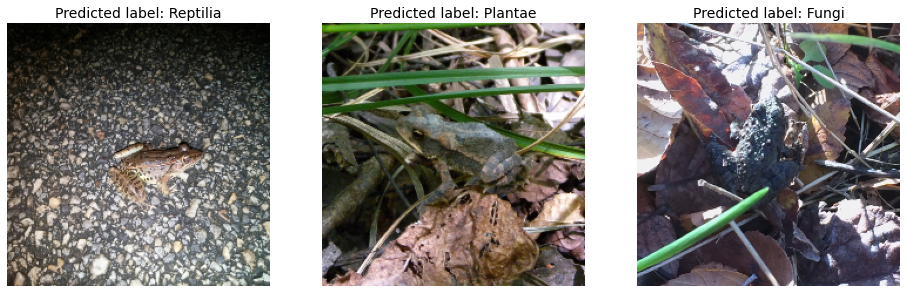




True Label :Animalia



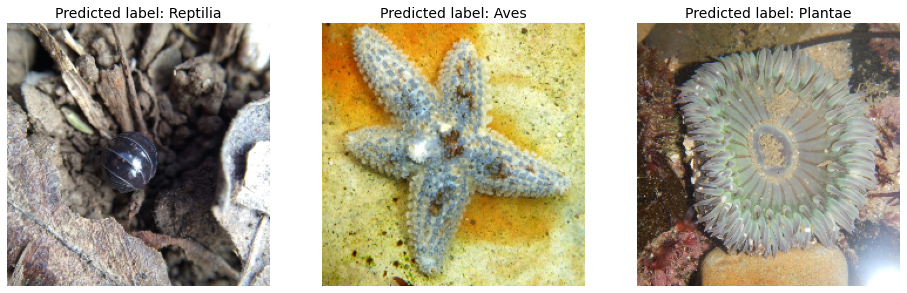




True Label :Arachnida



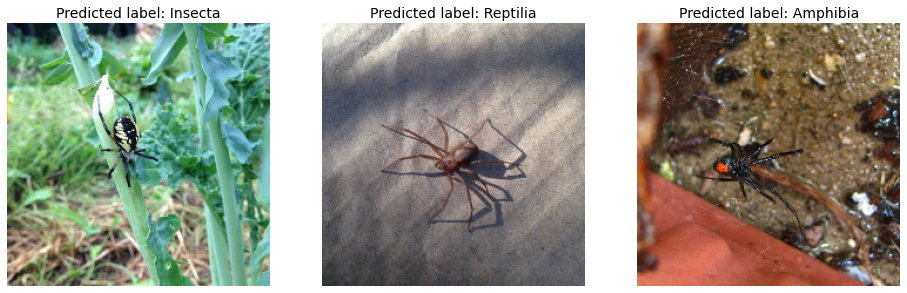




True Label :Aves



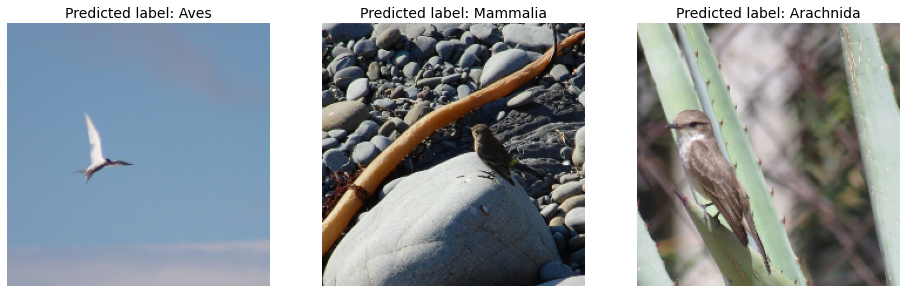




True Label :Fungi



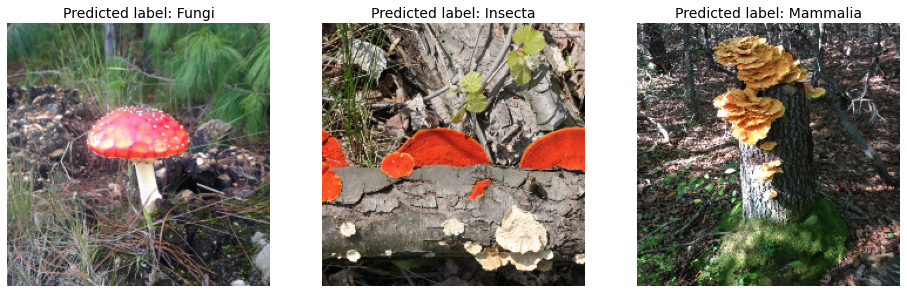




True Label :Insecta



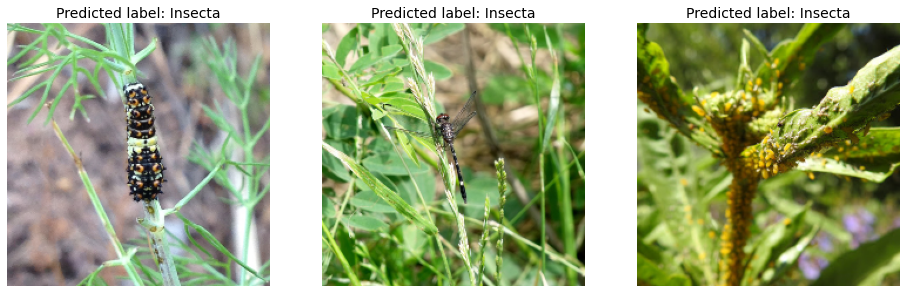




True Label :Mammalia



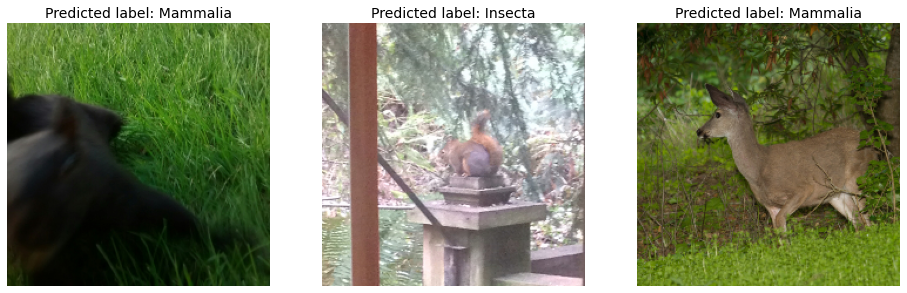




True Label :Mollusca



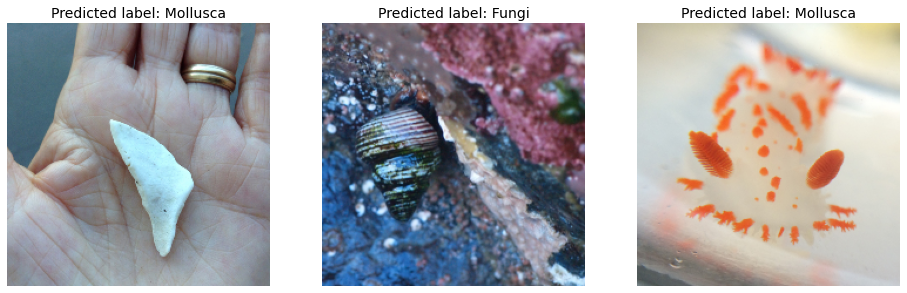




True Label :Plantae



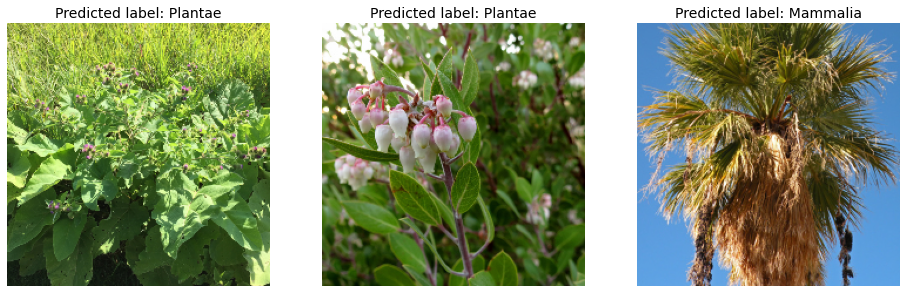




True Label :Reptilia



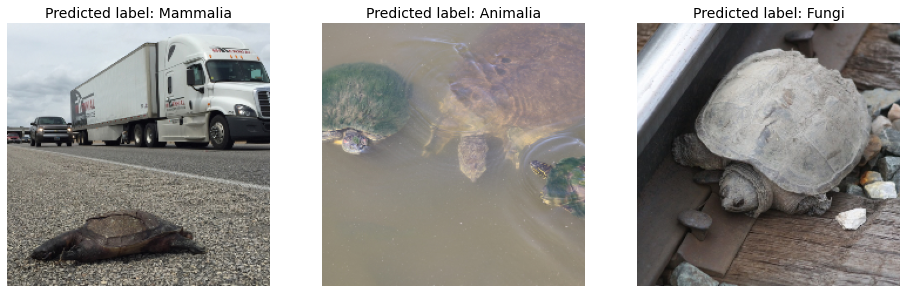

In [26]:
# Retrieve class names in alphabetical order
class_names_dict = train_generator.class_indices
class_names = class_names_dict.keys()
index_to_name = dict([(class_names_dict[key], key) for key in class_names_dict])

sample_images = []
for class_name in class_names:
    num_test_images = len(os.listdir("inaturalist_12K/val/"+class_name))
    test_images = os.listdir("inaturalist_12K/val/"+class_name)
    random_indices = np.random.randint(0, num_test_images, 3)
    print(f"\n\n\nTrue Label :{class_name}\n")
    plt.figure(figsize=(16, 5))
    for i, ind in enumerate(random_indices):
        image = plt.imread("inaturalist_12K/val/"+class_name+"/"+test_images[ind])
        # Resize input image to the model input shape
        resized_image = keras.preprocessing.image.smart_resize(image, input_image_shape[:2])/255.0
        # Predict the class
        pred = np.argmax(model.predict(np.array([resized_image])), axis=-1)[0]
        # Convert the index to the class label
        predicted_class = index_to_name[pred]
        plt.subplot(1, 3, i+1)
        plt.imshow(resized_image)
        plt.axis("off")
        plt.title(f"Predicted label: {predicted_class}", size=14)
    # wandb.log({f"True Label: {class_name}": plt})
    plt.show()

### Visualizing Filters

In [27]:
layer = model.layers[0]
filters, biases = layer.get_weights()

# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

num_filters = filters.shape[-1]

print(f"Shape of each filter = {filters.shape[:-1]}")
print(f"Number of filters = {num_filters}")

Shape of each filter = (3, 3, 3)
Number of filters = 32


In the below cell, we have plotted the filters. Each filter of the first convolutional layer is of shape (3, 3, 3). We have plotted each channel of the filter separately. Each row corresponds to the 3 channels in one filter. There are 32 filters in all (in the first convolutional layer).

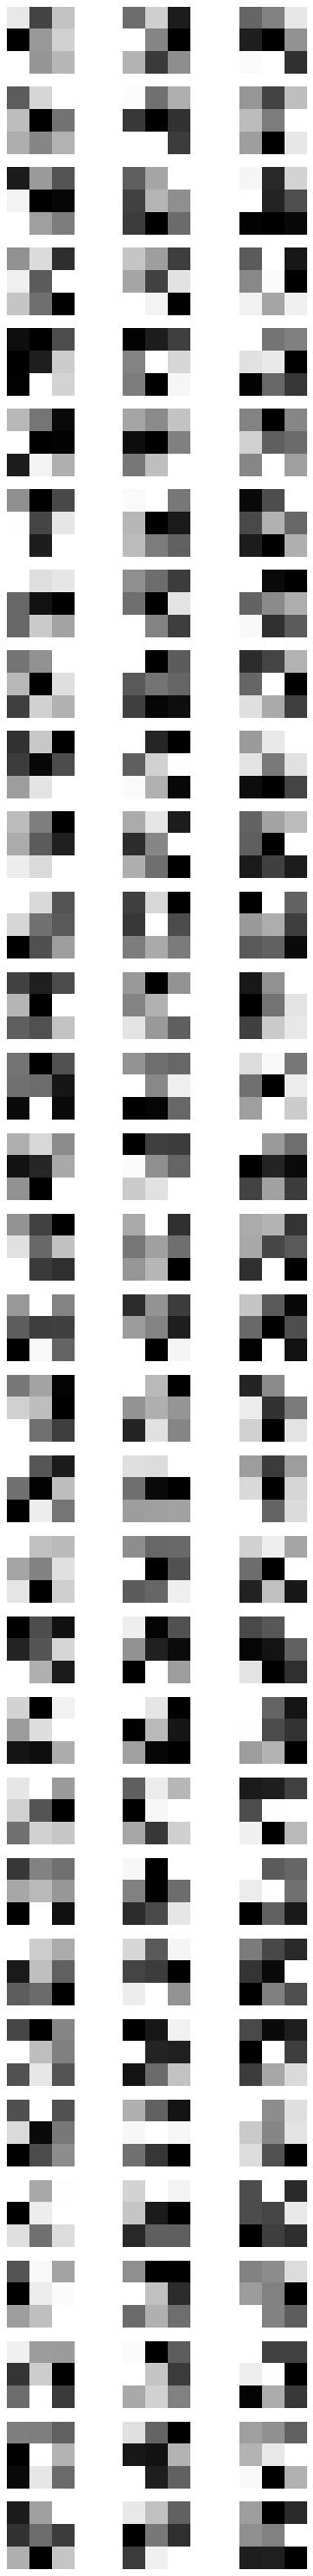

In [28]:
k = 1
plt.figure(figsize=(6, 48))
for i in range(num_filters):
    for j in range(3):
        f = filters[:, :, j, i]
        plt.subplot(num_filters, 3, k)
        k = k + 1
        plt.imshow(f, cmap="gray")
        plt.axis("off")
plt.show()